In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import datetime
import seaborn as sns
import scipy as sc
import random
import scipy.cluster.hierarchy as hac

In [2]:
shops = pd.read_csv("../data/shops.csv")
items = pd.read_csv("../data/items.csv")
item_categories = pd.read_csv("../data/item_categories.csv")
test = pd.read_csv("../data/test.csv")
sales_train = pd.read_csv("../data/sales_train.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [3]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
print(sales_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [56]:
from math import sqrt

def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

def spearman_correlation(x, y):
    r = stats.pearsonr(x, y)[0]
    return 1 - r # correlation to distance: range 0 to 2

# retrieving clusters, k is the number of clusters we want
from scipy.cluster.hierarchy import fcluster

def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters I'd like to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        print(cluster_indeces.values)
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot()
            plt.show()

In [57]:
grouped_sales_train = pd.DataFrame(sales_train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())

fig = go.Figure()
for shop_id in grouped_sales_train['shop_id'].unique():
        data = grouped_sales_train[grouped_sales_train['shop_id'] == shop_id]
        fig.add_trace(go.Scatter(x=data['date_block_num'], y=data['item_cnt_day'],
                    mode='lines+markers',
                    name='shop_id: '+ str(shop_id)))
fig.update_layout(legend_orientation="h", width=1600, height=1000, title="Plotting total 'item_cnt_day' amount across a 'date_block_num' for each 'shop_id'")
fig.show()

In [58]:
grouped_sales_train.head()

,shop_id,date_block_num,item_cnt_day
0,0,0,5578.0
1,0,1,6127.0
2,1,0,2947.0
3,1,1,3364.0
4,2,0,1146.0


### Clustering `shop_id` based on `item_cnt_day` for each `shop_id` per `date_block_num`

In [59]:
# Creating a timeseries df
timeSeries = pd.DataFrame()

for shop_id in grouped_sales_train['shop_id'].unique():
    shop_data_frame = pd.DataFrame(grouped_sales_train[grouped_sales_train['shop_id'] == shop_id]).filter(['date_block_num','item_cnt_day'])
    shop_data_frame = shop_data_frame.set_index('date_block_num')
    
    # adding missing date_block_num indexes with NaN values
    shop_data_frame = shop_data_frame.reindex(range(34))
    
    # filling the NaN values by mean  
    shop_data_frame.fillna(shop_data_frame.mean(), inplace=True)
    
    print(shop_data_frame)
    # adding the preprocessed shop dataframe to the timeSeries dataframe
    shop_data_frame = [item_cnt[0] for item_cnt in shop_data_frame.values.tolist()]
    shop_data_frame = pd.DataFrame([shop_data_frame], index=[shop_id])
    timeSeries = timeSeries.append(shop_data_frame)

                item_cnt_day
date_block_num              
0                     5578.0
1                     6127.0
2                     5852.5
3                     5852.5
4                     5852.5
5                     5852.5
6                     5852.5
7                     5852.5
8                     5852.5
9                     5852.5
10                    5852.5
11                    5852.5
12                    5852.5
13                    5852.5
14                    5852.5
15                    5852.5
16                    5852.5
17                    5852.5
18                    5852.5
19                    5852.5
20                    5852.5
21                    5852.5
22                    5852.5
23                    5852.5
24                    5852.5
25                    5852.5
26                    5852.5
27                    5852.5
28                    5852.5
29                    5852.5
30                    5852.5
31                    5852.5
32            

33                    1227.0
                item_cnt_day
date_block_num              
0                     8215.0
1                     7934.0
2                     9732.0
3                     7867.0
4                     6860.0
5                     8478.0
6                     7361.0
7                     7784.0
8                     9251.0
9                     8356.0
10                    8632.0
11                   12102.0
12                    6835.0
13                    6686.0
14                    6826.0
15                    5939.0
16                    5746.0
17                    6405.0
18                    5620.0
19                    6205.0
20                    6158.0
21                    6375.0
22                    7681.0
23                   12257.0
24                    6611.0
25                    5566.0
26                    6007.0
27                    6135.0
28                    5712.0
29                    5093.0
30                    4676.0
31            

33                    1320.0
                item_cnt_day
date_block_num              
0                     2115.0
1                     1824.0
2                     1977.0
3                     1540.0
4                     1724.0
5                     1654.0
6                     1329.0
7                     1610.0
8                     1742.0
9                     1647.0
10                    2092.0
11                    3037.0
12                    2153.0
13                    1917.0
14                    2125.0
15                    1517.0
16                    1865.0
17                    1788.0
18                    1807.0
19                    2109.0
20                    2097.0
21                    2117.0
22                    2694.0
23                    3679.0
24                    2410.0
25                    2131.0
26                    2100.0
27                    1813.0
28                    1879.0
29                    1740.0
30                    1700.0
31            

In [60]:
timeSeries

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,5578.000000,6127.000000,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000,...,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000,5852.500000
1,2947.000000,3364.000000,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000,...,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000,3155.500000
2,1146.000000,488.000000,753.000000,583.000000,553.000000,832.000000,807.000000,875.000000,945.000000,795.000000,...,987.000000,907.000000,762.000000,859.000000,843.000000,804.000000,785.000000,942.000000,822.000000,727.000000
3,767.000000,798.000000,959.000000,647.000000,710.000000,784.000000,721.000000,890.000000,1026.000000,793.000000,...,977.000000,738.000000,741.000000,740.000000,731.000000,672.000000,535.000000,666.000000,745.000000,613.000000
4,2114.000000,2025.000000,2060.000000,285.000000,1211.000000,1464.000000,1378.000000,1713.000000,1536.000000,1482.000000,...,1188.000000,980.000000,978.000000,899.000000,893.000000,793.000000,842.000000,947.000000,732.000000,831.000000
5,1295.818182,877.000000,1355.000000,1008.000000,1110.000000,1393.000000,1265.000000,1510.000000,1298.000000,1267.000000,...,1404.000000,1101.000000,1109.000000,1054.000000,1012.000000,954.000000,991.000000,1294.000000,1092.000000,1052.000000
6,3686.000000,4007.000000,4519.000000,3168.000000,3022.000000,3847.000000,3360.000000,3702.000000,4208.000000,3675.000000,...,2328.000000,2329.000000,1981.000000,1998.000000,1748.000000,1539.000000,1484.000000,1575.000000,1725.000000,1802.000000
7,2495.000000,2513.000000,2460.000000,1540.000000,1647.000000,2085.000000,2031.000000,2397.000000,2599.000000,2236.000000,...,2084.000000,1847.000000,1430.000000,1340.000000,1217.000000,1235.000000,1327.000000,1409.000000,1287.000000,1212.000000
8,1463.000000,1156.000000,977.000000,-1.000000,898.750000,898.750000,898.750000,898.750000,898.750000,898.750000,...,898.750000,898.750000,898.750000,898.750000,898.750000,898.750000,898.750000,898.750000,898.750000,898.750000
9,3966.500000,3966.500000,3966.500000,3966.500000,3966.500000,3966.500000,3966.500000,3966.500000,3966.500000,6526.000000,...,3966.500000,3966.500000,3966.500000,-1.000000,3966.500000,3966.500000,3966.500000,3966.500000,3966.500000,3186.000000


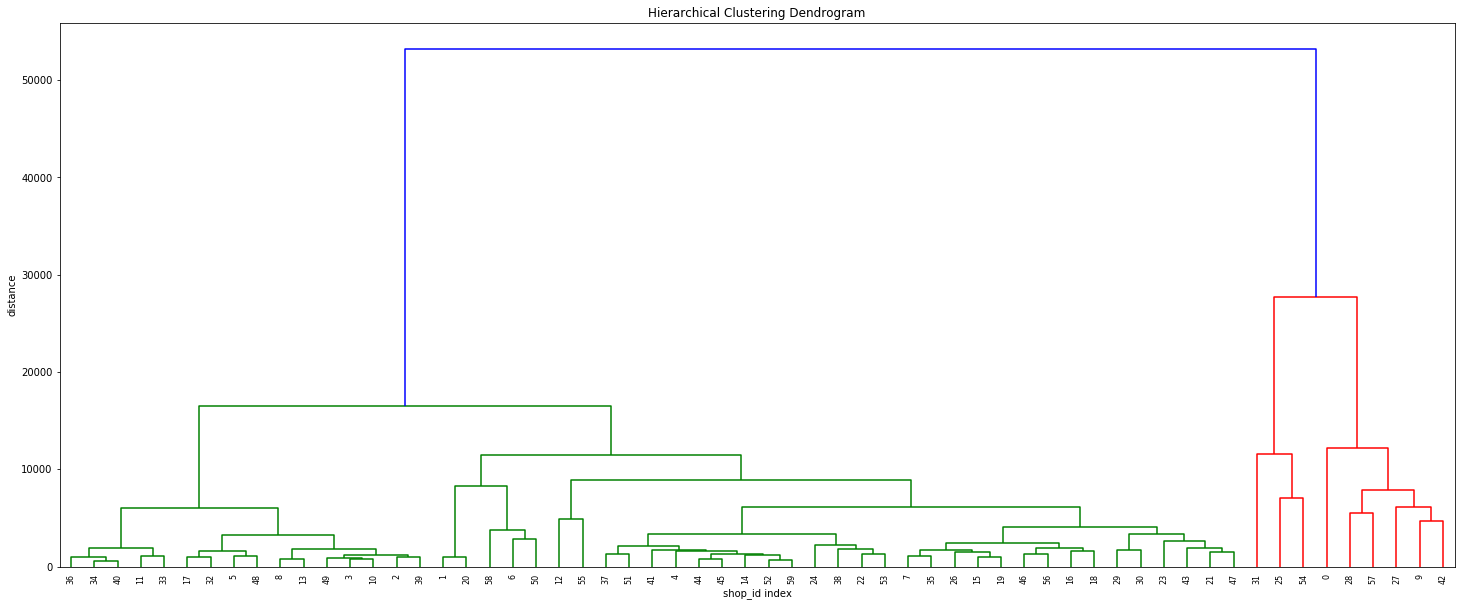

Cluster 5 number of entries 1
[0]
Cluster 2 number of entries 35
[ 1  4  6  7 12 14 15 16 18 19 20 21 22 23 24 26 29 30 35 37 38 41 43 44
 45 46 47 50 51 52 53 55 56 58 59]
Cluster 1 number of entries 16
[ 2  3  5  8 10 11 13 17 32 33 34 36 39 40 48 49]
Cluster 4 number of entries 5
[ 9 27 28 42 57]
Cluster 3 number of entries 3
[25 31 54]


In [61]:
Z = hac.linkage(timeSeries, method='complete', metric=DTWDistance)

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('shop_id index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

print_clusters(timeSeries, Z, 5, plot=False)

### Clustering `item_category_id` based on  `item_cnt_day` per `date_block_num`

In [62]:
train = sales_train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()
train.head()
grouped_sales_train = pd.DataFrame(train.groupby(['item_category_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig = go.Figure()
for item_cat in grouped_sales_train['item_category_id'].unique():
        data = grouped_sales_train[grouped_sales_train['item_category_id'] == item_cat]
        fig.add_trace(go.Scatter(x=data['date_block_num'], y=data['item_cnt_day'],
                    mode='lines+markers',
                    name='item cat: '+ str(item_cat)))
fig.update_layout(legend_orientation="h", width=1600, height=1000, title="Plotting total 'item_cnt_day' amount across a 'date_block_num' for each 'item_category_id'")
fig.show()

In [63]:
grouped_sales_train.head()

,item_category_id,date_block_num,item_cnt_day
0,0,0,1.0
1,0,1,1.0
2,0,3,1.0
3,1,0,1.0
4,1,1,1.0


In [64]:
# Creating a timeseries df
cat_timeSeries = pd.DataFrame()

for cat_id in grouped_sales_train['item_category_id'].unique():
    cat_data_frame = pd.DataFrame(grouped_sales_train[grouped_sales_train['item_category_id'] == cat_id]).filter(['date_block_num','item_cnt_day'])
    cat_data_frame = cat_data_frame.set_index('date_block_num')
    
    # adding missing date_block_num indexes with NaN values
    cat_data_frame = cat_data_frame.reindex(range(34))
    
    # filling the NaN values
    cat_data_frame.fillna(cat_data_frame.mean(), inplace=True)
    
    # adding the preprocessed category item dataframe to the timeSeries dataframe
    cat_data_frame = [item_cnt[0] for item_cnt in cat_data_frame.values.tolist()]
    cat_data_frame = pd.DataFrame([cat_data_frame], index=[cat_id])
    cat_timeSeries = cat_timeSeries.append(cat_data_frame)

In [65]:
cat_timeSeries

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1390.000000,1190.000000,1025.000000,646.000000,596.000000,667.000000,618.000000,674.000000,792.000000,790.000000,...,370.000000,307.000000,229.000000,170.000000,146.000000,104.000000,114.000000,132.000000,89.000000,82.000000
3,440.000000,302.000000,293.000000,202.000000,146.000000,150.000000,233.000000,300.000000,383.000000,391.000000,...,1398.000000,834.000000,773.000000,746.000000,667.000000,559.000000,603.000000,975.000000,1090.000000,1059.000000
4,251.000000,220.000000,226.000000,160.000000,175.000000,176.000000,179.000000,140.000000,86.000000,89.000000,...,10.000000,2.000000,2.000000,2.000000,2.000000,1.000000,77.645161,1.000000,77.645161,77.645161
5,623.000000,358.000000,354.000000,275.000000,281.000000,329.000000,355.000000,299.000000,289.000000,257.000000,...,178.000000,85.000000,88.000000,67.000000,44.000000,51.000000,48.000000,45.000000,31.000000,44.000000
6,870.000000,668.000000,646.000000,465.000000,441.000000,502.000000,622.000000,637.000000,729.000000,1016.000000,...,700.000000,400.000000,334.000000,266.000000,274.000000,319.000000,243.000000,277.000000,237.000000,242.000000
7,382.714286,382.714286,382.714286,382.714286,382.714286,382.714286,382.714286,382.714286,382.714286,382.714286,...,639.000000,220.000000,269.000000,244.000000,217.000000,238.000000,178.000000,307.000000,244.000000,205.000000
8,1245.363636,1245.363636,1245.363636,1245.363636,1245.363636,1245.363636,1245.363636,1245.363636,1245.363636,1245.363636,...,1245.363636,1245.363636,1245.363636,45.000000,147.000000,117.000000,193.000000,483.000000,5128.000000,-1.000000
9,149.000000,159.000000,211.000000,138.000000,95.000000,124.000000,83.000000,124.000000,141.000000,253.000000,...,467.000000,480.000000,492.000000,1003.000000,2005.000000,528.000000,513.000000,276.000000,816.000000,2524.000000


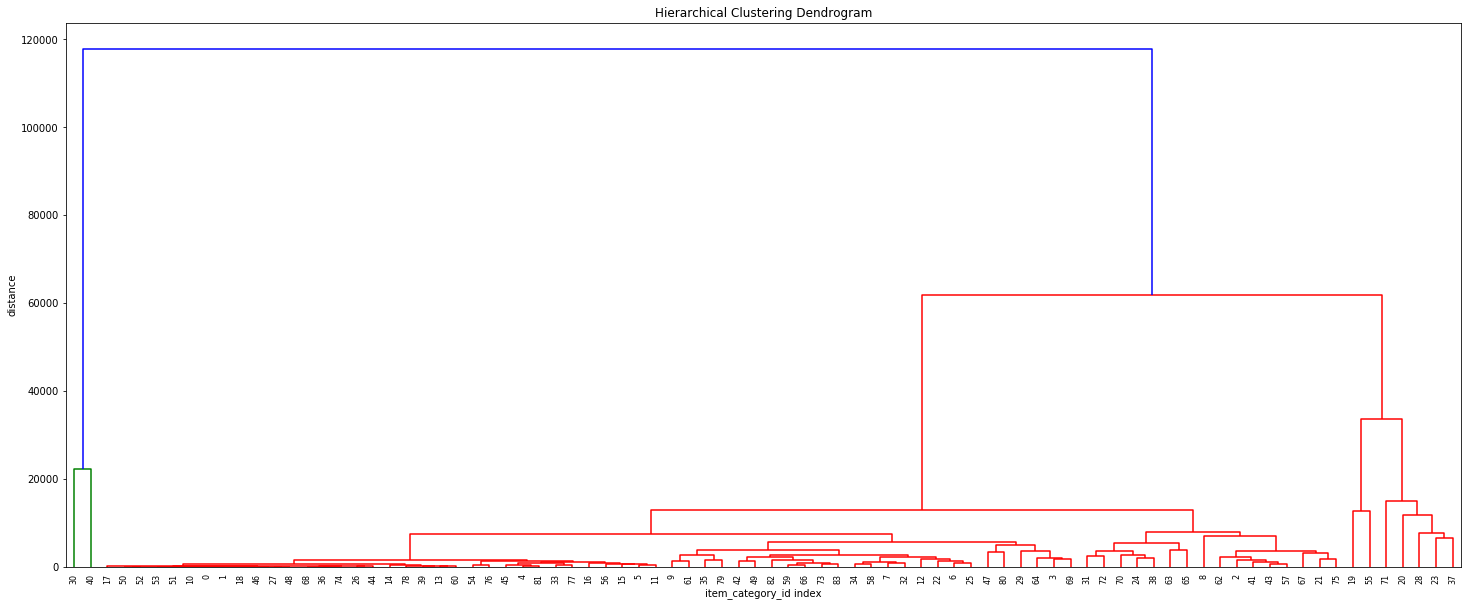

Cluster 3 number of entries 34
[ 0  1  4  5 10 11 13 14 15 16 17 18 26 27 33 36 39 44 45 46 48 50 51 52
 53 54 56 60 68 74 76 77 78 81]
Cluster 12 number of entries 8
[ 2 21 41 43 57 62 67 75]
Cluster 7 number of entries 4
[ 3 29 64 69]
Cluster 5 number of entries 15
[ 6  7 12 22 25 32 34 42 49 58 59 66 73 82 83]
Cluster 13 number of entries 1
[8]
Cluster 4 number of entries 4
[ 9 35 61 79]
Cluster 14 number of entries 1
[19]
Cluster 19 number of entries 1
[20]
Cluster 16 number of entries 1
[23]
Cluster 9 number of entries 3
[24 38 70]
Cluster 18 number of entries 1
[28]
Cluster 1 number of entries 1
[30]
Cluster 8 number of entries 2
[31 72]
Cluster 17 number of entries 1
[37]
Cluster 2 number of entries 1
[40]
Cluster 6 number of entries 2
[47 80]
Cluster 15 number of entries 1
[55]
Cluster 10 number of entries 1
[63]
Cluster 11 number of entries 1
[65]
Cluster 20 number of entries 1
[71]


In [66]:
Z = hac.linkage(cat_timeSeries, method='complete', metric=DTWDistance)

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('item_category_id index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

print_clusters(cat_timeSeries, Z, 20, plot=False)

In [67]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [68]:
item_categories[item_categories['item_category_id'] == 80]

,item_category_name,item_category_id
80,Служебные - Билеты,80


In [69]:
item_categories[item_categories['item_category_id'] == 47]

,item_category_name,item_category_id
47,"Книги - Комиксы, манга",47
